In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import SaltRemover as sr
remover = sr.SaltRemover()

In [4]:
df1 = pd.read_csv('final_total.csv', sep=' ', na_values=['na'])
df1 = df1.dropna(ignore_index=True)
df1

,CHEMBLID,smiles,ido_ic50,tdo_ic50
0,CHEMBL1098875,O=C1c2cc(F)ccc2-n2c1nc1ccccc1c2=O,23.0,60.0
1,CHEMBL1209728,Cc1c(Br)oc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C,10000.0,10000.0
2,CHEMBL1276265,O=C1c2ccc(Cl)cc2-n2c1nc1ccccc1c2=O,183.0,224200.0
3,CHEMBL1346056,Oc1ccccc1-c1nc2c3ccccc3c3ccccc3c2[nH]1,11790.0,12250.0
4,CHEMBL139935,O=[N+]([O-])c1cc(F)c2cccnc2c1O,14610.0,30230.0
...,...,...,...,...
755,CHEMBL5221020,O[C@@H]1CCCC[C@H]1CNc1c(Br)ccc2[nH]ncc12,1230.0,11240.0
756,CHEMBL5221102,Brc1cc(NC[C@H]2CCCN2)c2cn[nH]c2c1,56450.0,7450.0
757,CHEMBL578036,CC1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(CO)coc2-1,10000.0,450.0
758,CHEMBL584991,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,50.0,10000.0


In [5]:
df1.loc[:, 'ido_ic50'] = (np.log10((df1.loc[:, 'ido_ic50'])*10**(-9)))*(-1)
df1.loc[:, 'tdo_ic50'] = (np.log10((df1.loc[:, 'tdo_ic50'])*10**(-9)))*(-1)

In [6]:
df2 = df1.loc[:, ['ido_ic50', 'tdo_ic50']]
df2

,ido_ic50,tdo_ic50
0,7.638272,7.221849
1,5.000000,5.000000
2,6.737549,3.649364
3,4.928486,4.911864
4,4.835350,4.519562
...,...,...
755,5.910095,4.949234
756,4.248336,5.127844
757,5.000000,6.346787
758,7.301030,5.000000


In [7]:
for i in range(len(df2)):
    if df2['ido_ic50'].values[i] >= 6.15:
        df2.loc[i, ['ido_ic50']] = 1
    else:
        df2.loc[i, ['ido_ic50']] = 0

In [8]:
for i in range(len(df2)):
    if df2['tdo_ic50'].values[i] >= 6.0:
        df2.loc[i, ['tdo_ic50']] = 1
    else:
        df2.loc[i, ['tdo_ic50']] = 0

In [9]:
df2

,ido_ic50,tdo_ic50
0,1.0,1.0
1,0.0,0.0
2,1.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
755,0.0,0.0
756,0.0,0.0
757,0.0,1.0
758,1.0,0.0


In [10]:
newcol = []
for i in range(len(df2)):
    if df2['ido_ic50'].values[i] == 1.0 and df2['tdo_ic50'].values[i] == 1.0:
        newcol.append('AA')
    elif df2['ido_ic50'].values[i] == 0.0 and df2['tdo_ic50'].values[i] == 0.0:
        newcol.append('II')
    elif df2['ido_ic50'].values[i] == 0.0 and df2['tdo_ic50'].values[i] == 1.0:
        newcol.append('IA')
    else:
        newcol.append('AI')

In [11]:
target = pd.DataFrame(data=newcol, columns=['ido_tdo'])
target

,ido_tdo
0,AA
1,II
2,AI
3,II
4,II
...,...
755,II
756,II
757,IA
758,AI


In [12]:
encoder = LabelEncoder()
y_label = encoder.fit_transform(target['ido_tdo'])

In [13]:
y_label

array([0, 3, 1, 3, 3, 3, 2, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 0, 2, 3, 3, 1, 2, 1, 2, 3, 3, 2, 3,
       3, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 1, 3, 0, 0,
       1, 3, 0, 2, 1, 3, 3, 1, 0, 1, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 1, 0,
       3, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 3, 0, 0, 3, 0, 0, 3,
       0, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 3, 1, 1, 2, 0, 3, 3, 0, 0, 3, 0, 3,
       0, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 3, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 3, 0, 3, 3, 3, 2, 2, 0, 1, 0, 2, 3, 0, 0, 1, 0, 0, 0,
       3, 3, 0, 0, 3, 3, 1, 2, 3, 0, 3, 0, 2, 0, 1, 3, 1, 0, 0, 3, 3, 0,
       0, 2, 1, 0, 3, 0, 3, 3, 0, 3, 3, 1, 1, 3, 3,

In [14]:
mols = []
for i in range(len(df1)):
    try:
        mol_i = Chem.MolFromSmiles(df1['smiles'][i])
        if mol_i is None:
            print(f"[WARNING] Invalid SMILES at index {i}, skipping.")
            mols.append(None)  # Maintain indexing for multiprocessing
            continue
        mol_i = remover.StripMol(mol_i, dontRemoveEverything=True)
        mols.append(mol_i)
    except Exception as e:
        print(e)
len(mols)

760

In [15]:
#Morgan Fingerprints:
fpgen2 = AllChem.GetMorganGenerator(fpSize=1024)
i = 0
l2 = np.zeros((1, 1024), dtype='uint8')
for mol in mols:
    fp2 = fpgen2.GetFingerprintAsNumPy(mols[i])
    l2 = np.vstack((l2, fp2))
    i += 1
MFPs = l2[1:, :]
MFPs.shape

(760, 1024)

In [16]:
FP_df = pd.DataFrame(MFPs)
FP_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
756,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
757,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
x = FP_df.values

In [18]:
from sklearn.decomposition import PCA

In [21]:
from sklearn.manifold import TSNE

In [20]:
reduced_data = PCA(n_components=2).fit_transform(x)

In [22]:
tsne = TSNE(n_components=2, random_state=42)

In [23]:
reduced_data_tsne = tsne.fit_transform(x)

In [23]:
reduced_data_pca = PCA(n_components=2, random_state=42).fit_transform(x)

In [24]:
reduced_data_tsne.shape

(760, 2)

In [25]:
#DBSCAN assumes that the clustering criterion (i.e. density requirement) is globally homogeneous. 
#In other words, DBSCAN may struggle to successfully capture clusters with different densities. 
#HDBSCAN alleviates this assumption and explores all possible density scales 

In [26]:
#One immediate advantage is that HDBSCAN is scale-invariant.

In [18]:
#Without dimension reduction
hdb = HDBSCAN(min_cluster_size=20, min_samples=10).fit(x)

In [20]:
#As you can see, there are 12 clusters without dimension reduction
np.unique(hdb.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [24]:
#with dimension reduction:
hdb = HDBSCAN(min_cluster_size=20, min_samples=10).fit(reduced_data_tsne)

In [25]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

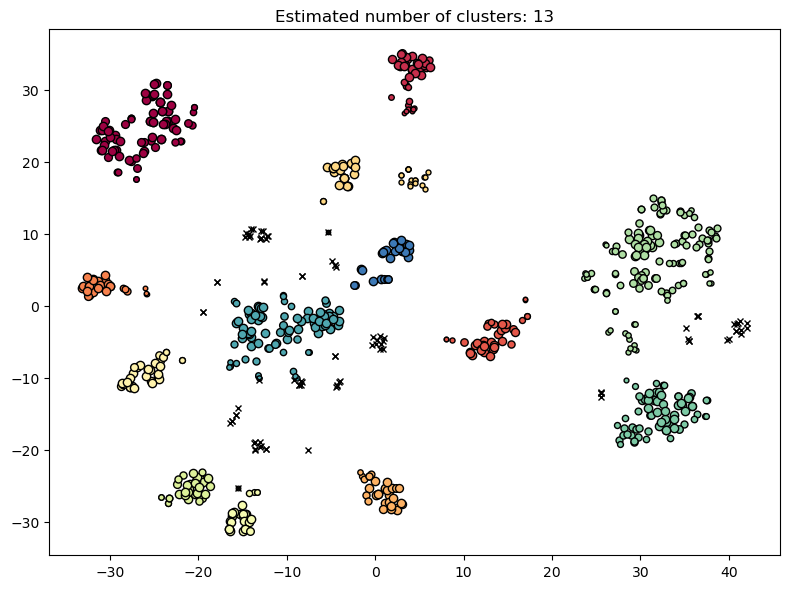

In [26]:
plot(reduced_data_tsne, hdb.labels_, hdb.probabilities_)
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])

    unique_labels = sorted(set(labels))
    cmap = plt.colormaps.get_cmap("tab20")  # modern API, no extra argument

    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}

    for k in unique_labels:
        if k == -1:
            # Black for noise
            col = (0, 0, 0, 1)
            marker = "x"
            cluster_name = "Noise"
        else:
            # Cycle through colormap if clusters > 20
            col = cmap(k % cmap.N)
            marker = "o"
            cluster_name = f"Cluster {k}"

        class_index = np.where(labels == k)[0]
        sizes = [30 if k == -1 else 50 + 100 * proba_map[ci] for ci in class_index]

        if marker == "x":
            ax.scatter(
                X[class_index, 0],
                X[class_index, 1],
                c=[col],
                s=sizes,
                marker=marker,
                facecolor=col,   # avoid edgecolor warning
                label=cluster_name,
                alpha=0.8
            )
        else:
            ax.scatter(
                X[class_index, 0],
                X[class_index, 1],
                c=[col],
                s=sizes,
                marker=marker,
                edgecolor="k",
                linewidth=0.5,
                label=cluster_name,
                alpha=0.8
            )

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title, fontsize=14)

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10, frameon=True)
    ax.set_xlabel("t-SNE 1", fontsize=12)
    ax.set_ylabel("t-SNE 2", fontsize=12)
    plt.tight_layout()


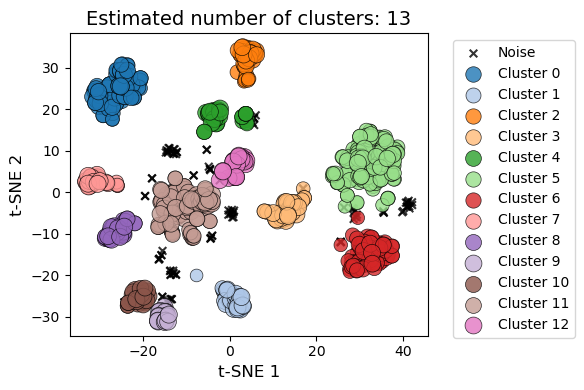

In [50]:
plot_clusters(reduced_data_tsne, hdb.labels_, hdb.probabilities_)
plt.show()

In [16]:
#that HDBSCAN can yield qualitatively better classes of clusterings without users’ intervention 
#which are inaccessible via DBSCAN.

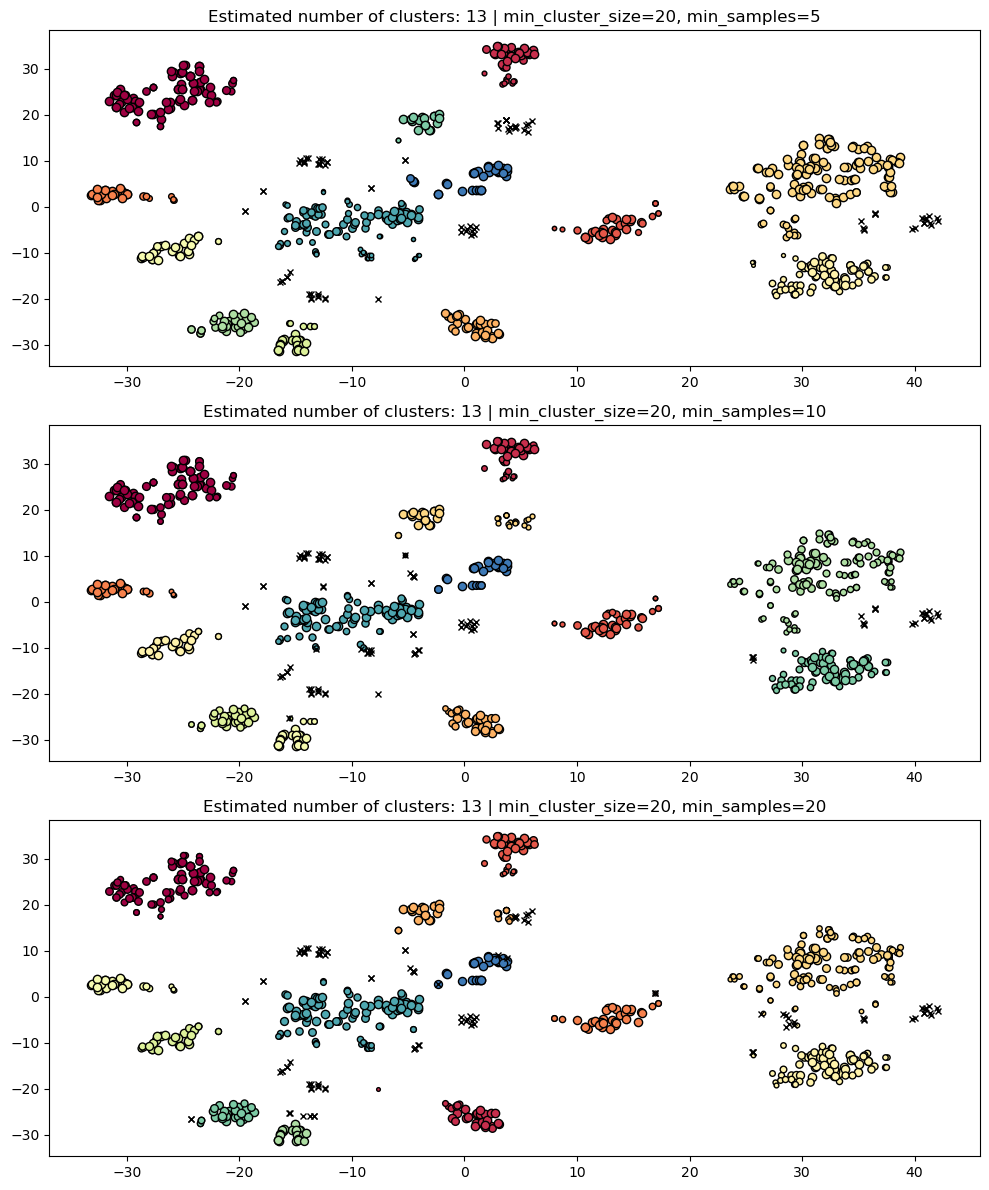

In [34]:
PARAM = (
    {"min_cluster_size": 20, "min_samples": 5},
    {"min_cluster_size": 20, "min_samples": 10},
    {"min_cluster_size": 20, "min_samples": 20},
)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(reduced_data_tsne)
    labels = hdb.labels_

    plot(reduced_data_tsne, labels, hdb.probabilities_, param, ax=axes[i])
plt.show()